In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
from geopy.distance import geodesic
import math
import random
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import statistics

### Datasets

In [2]:
def getTDCSBSchools():
    return pd.read_csv('../res/datasets/schools/TDCSB_Schools.csv', sep = ',')

tdcsbSchools = getTDCSBSchools()

In [3]:
def getPedestrian():
    pedestrian = pd.read_csv('../res/datasets/pedestrian/Pedestrian_Network_Data.csv', sep = ',')
    cols = ['OBJECTID', '_id', 'CROSSWALK_TYPE', 'SIDEWALK_CODE', 'CROSSWALK', 'PX_TYPE', 'PX']
    return pedestrian.drop(cols, axis=1)

In [4]:
coordinates = tdcsbSchools.drop(['_id', 'OBJECTID', 'TCDSB_CODE', 'SCH_NAME','ADDRESS_FULL', 'MUNICIPALITY', 'POSTAL_CODE', 'TCDSB_LEVEL', 'STATUS'], axis = 1)

In [5]:
coordinates = coordinates['geometry'].astype('str')
coordinates = coordinates.apply(lambda x: ast.literal_eval(x))
coordinates = coordinates.apply(pd.Series)

In [6]:
#these are not data frames but instead series 
#be careful when working with them

Latitude = coordinates['coordinates'].apply(lambda x: x[1])
Longitude = coordinates['coordinates'].apply(lambda x: x[0])

### Parameters

In [7]:
STD_DEV = 0.4
PT_DENSITY = 50

### Scoring Functions

In [8]:
def getDistance(origin, stationCor):
    return abs(geodesic(origin, stationCor).meters/1000)

In [9]:
def score(latStation, longStation, latOrigin, longOrigin, stdDev):
    
    stationCor = (latStation, longStation)
    
    totalScore = 0
    count = 0
    
    for Lat, Long in zip(latOrigin, longOrigin):
        origin = (Lat, Long)
        r = getDistance(origin, stationCor)
        # this score function simply uses the traditional gaussian distribution formula,
        # except it extracts all the common parts to be multiplied last for efficiency.
        score =  math.exp(-0.5*((r**2) / (stdDev**2)))
        totalScore += score
            
    #adjustFactor = 210 * 0.9974
    #totalScore = (totalScorePre/adjustFactor)*100
    
    # Multiply common part in gaussian distribution formula
    totalScore *= (1/(stdDev * math.sqrt(2 * math.pi)))
    
    return totalScore

In [10]:
def generateGridScores(upperLatBound, bottomLatBound, leftLongBound, rightLongBound):
    scores = pd.DataFrame(columns = ['lat', 'long', 'score'])
    latStep = round((upperLatBound-bottomLatBound)/PT_DENSITY, 4)
    longStep = round((rightLongBound-leftLongBound)/PT_DENSITY, 4)

    for lat in np.arange(bottomLatBound, upperLatBound, latStep):
        for long in np.arange(leftLongBound, rightLongBound, longStep):
            pointScore = score(lat, long, Latitude, Longitude, STD_DEV);
            pointScore = pointScore if pointScore > 0.1 else 0.0;
            pointScoreDict = {'lat' : [lat], 'long' : [long], 'score' : [pointScore]};
            pointScoreDf = pd.DataFrame(data=pointScoreDict)
            scores = pd.concat([scores, pointScoreDf], ignore_index = True)

            # print(score(lat, long, 0.4, Latitude, Longitude))
            # plot like this: lat - bottomLatBound,  long - leftLongBound
    return scores

### Regression

In [11]:
def linearRegression(scores):
    # step 1: don't use points that are very small (threshold)
    threshold = statistics.median(scores['score'])
    thresholded_scores = scores.loc[scores['score'] >= threshold]
    #print(thresholded_scores)
    
    regr = LinearRegression()
    lats = thresholded_scores["lat"].values.reshape(-1, 1)
    longs = thresholded_scores["long"].values.reshape(-1, 1)
    regr.fit(lats, longs, thresholded_scores["score"]) # Score is Squared because sample_weight is square rooted thresholded_scores["score"]
    x_begin = lats[0]
    x_end = lats[-1]
    y_begin = regr.predict(x_begin.reshape(1, -1)).item()
    y_end = regr.predict(x_end.reshape(1, -1)).item()
    
    return (x_begin.item(), x_end.item(), y_begin, y_end)

In [12]:
def polynomialRegression(scores, degree, upperLatBound, bottomLatBound):
    poly = PolynomialFeatures(degree, include_bias=False)
    poly_features = poly.fit_transform(scores["lat"].values.reshape(-1, 1))
    poly_reg_model = LinearRegression().fit(poly_features, scores["long"], scores["score"])
    #x = scores['lat'].unique()
    x = np.arange(bottomLatBound, upperLatBound, round((upperLatBound-bottomLatBound)/PT_DENSITY, 4))
    y = poly_reg_model.predict(poly.fit_transform(x.reshape(-1, 1)))
    return (x, y, poly_reg_model.intercept_, poly_reg_model.coef_)

### Filtering and Processing

In [13]:
def trimOutOfBounds(points, upperLatBound, bottomLatBound, leftLongBound, rightLongBound):
    df = pd.DataFrame({'lat': points[0], 'long': points[1]})
    df = df.loc[(df['lat'] >= bottomLatBound) & (df['lat'] <= upperLatBound) & (df['long'] >= leftLongBound) & (df['long'] <= rightLongBound)]
    return (df['lat'].values, df['long'].values)

In [14]:
def snapLongToGrid(points, leftLongBound, rightLongBound):
    step = round((rightLongBound-leftLongBound)/PT_DENSITY, 4)
    pointsDf = pd.DataFrame({'lat': points[0], 'long': points[1]})
    for index, row in pointsDf.iterrows():
        pointsDf.at[index, 'long'] = pointsDf.at[index, 'long'] - ((pointsDf.at[index, 'long'] - leftLongBound) % step)
    return (pointsDf['lat'].values, pointsDf['long'].values)

### Plotting Functions

In [15]:
def plotScores(scores):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.scatter(scores["lat"], scores["long"], scores["score"])
    return ax

In [16]:
def plotScoresWithLine(scores, line):
    ax = plotScores(scores)
    ax.plot([line[0], line[1]], [line[2], line[3]], [0, 0], color='red', linewidth=3)
    return ax

In [17]:
def plotScoresWithCurve(scores, curve):
    ax = plotScores(scores)
    ax.scatter(curve[0], curve[1], 0)
    return ax

In [18]:
def plotHeatmap(scores, line):
    y_begin = line[2]
    y_end = line[3]
    fig = plt.figure()
    ax = sns.heatmap(scores.pivot("long", "lat", "score"))
    y_begin_hm = int((y_begin - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)
    y_end_hm = int((y_end - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)
    ax.plot([0, PT_DENSITY], [y_begin_hm, y_end_hm], linewidth=3, color='r')
    return ax

In [19]:
def plotHeatmapPolynomial(scores, curves):
    fig = plt.figure()
    ax = sns.heatmap(scores.pivot("long", "lat", "score"))
    for curve in curves:
        x = curve[0]
        y = curve[1]
        x_hm = [int(a) for a in ((x - scores["lat"].iloc[0]) / (scores["lat"].iloc[-1] - scores["lat"].iloc[0]) * PT_DENSITY)]
        y_hm = [int(a) for a in ((y - scores["long"].iloc[0]) / (scores["long"].iloc[-1] - scores["long"].iloc[0]) * PT_DENSITY)]
        ax.scatter(x_hm, y_hm, linewidth=1)
    return ax

### Toronto (YYZ)

In [20]:
# let coords only have 4 decimal points precision in ALL functions
YYZ_UpperLatBound = round(43.806535, 4)
YYZ_BottomLatBound = round(43.567208, 4)
YYZ_LeftLongBound = round(-79.597003, 4)
YYZ_RightLongBound = round(-79.322181, 4)

YYZ_Scores = generateGridScores(YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)

<Axes3DSubplot:>

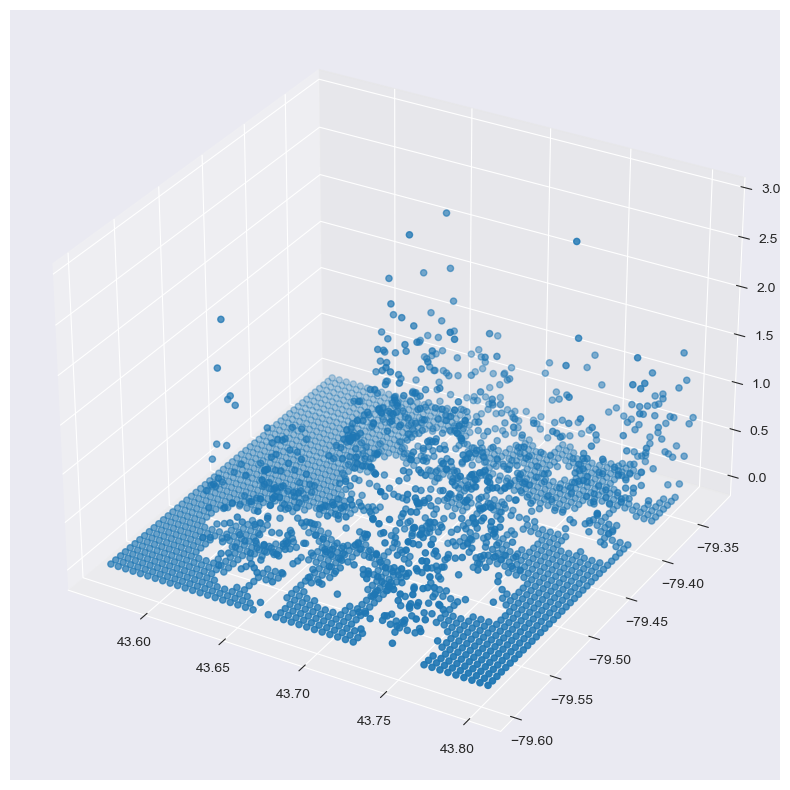

In [21]:
plotScores(YYZ_Scores)

In [22]:
[*YYZ_Line_1, YYZ_Line_1_intercept, YYZ_Line_1_coefficients] = polynomialRegression(YYZ_Scores, 3, YYZ_UpperLatBound, YYZ_BottomLatBound)
YYZ_Line_1 = trimOutOfBounds(YYZ_Line_1, YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)
YYZ_Line_1 = snapLongToGrid(YYZ_Line_1, YYZ_LeftLongBound, YYZ_RightLongBound)

<Axes3DSubplot:>

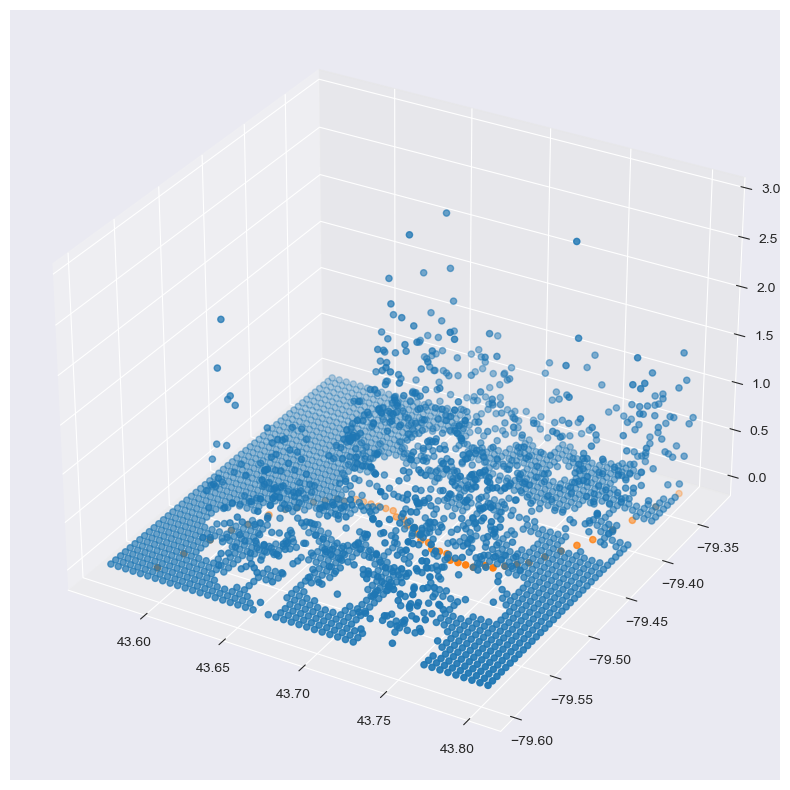

In [23]:
plotScoresWithCurve(YYZ_Scores, YYZ_Line_1)

<AxesSubplot:xlabel='lat', ylabel='long'>

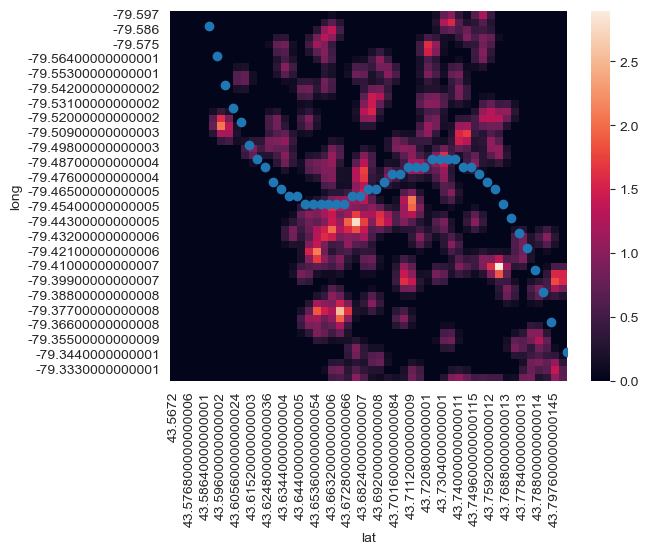

In [24]:
plotHeatmapPolynomial(YYZ_Scores, [YYZ_Line_1])

### Clustering Test

In [71]:
NUM_CLUSTERS = 5

In [72]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
YYZ_C_Scores = YYZ_Scores.copy()
YYZ_C_Scores = YYZ_C_Scores.loc[YYZ_C_Scores['score'] > 0.5]

In [73]:
#for index, row in YYZ_C_Scores.iterrows():
#    YYZ_C_Scores.at[index, 'score'] = (YYZ_C_Scores.at[index, 'score']*2)**2

In [74]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0).fit(YYZ_C_Scores[["lat", "long"]], 0, YYZ_C_Scores["score"])

In [75]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=0).fit(YYZ_C_Scores[["lat", "long"]])
    distortions.append(kmeanModel.inertia_)

C:\Users\trieu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


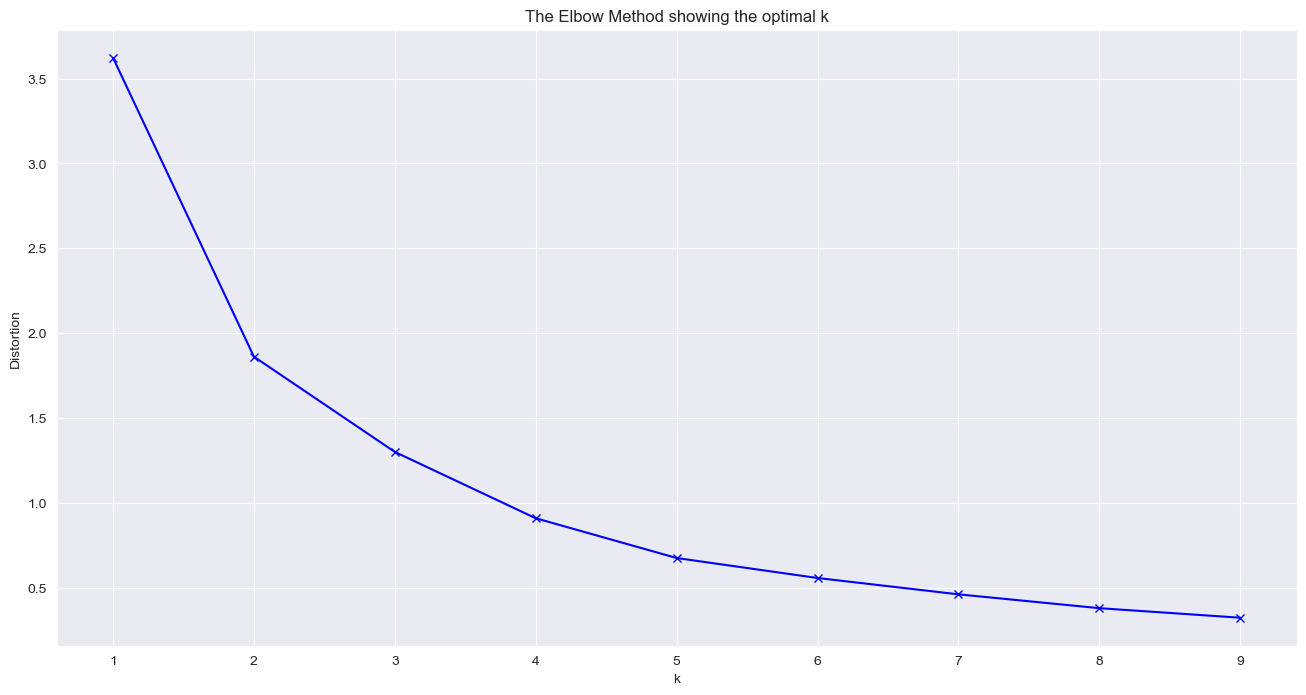

In [76]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

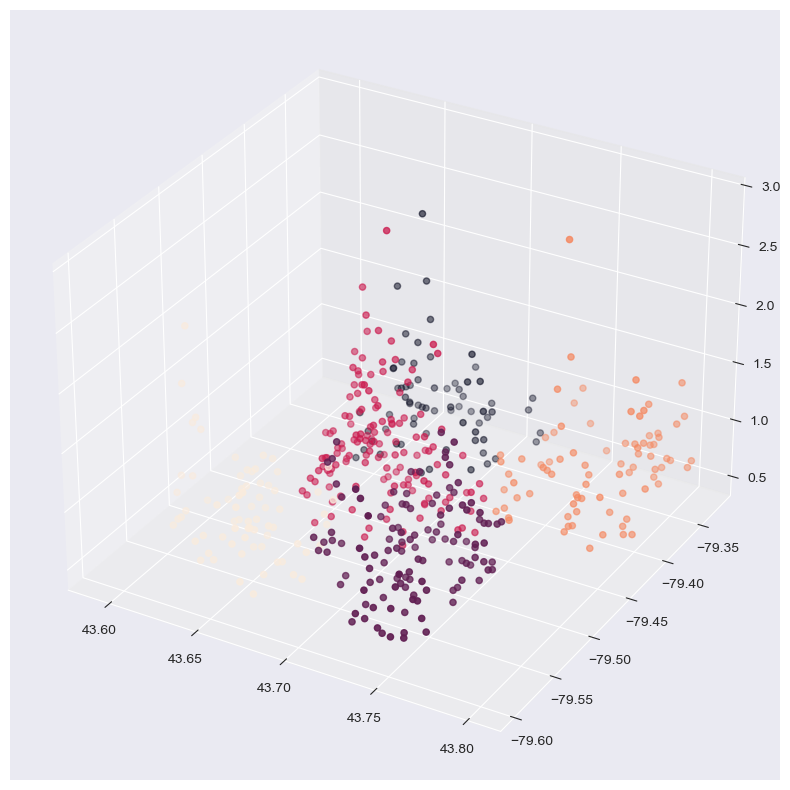

In [77]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(YYZ_C_Scores["lat"], YYZ_C_Scores["long"], YYZ_C_Scores["score"], c=kmeans.labels_.astype(float))

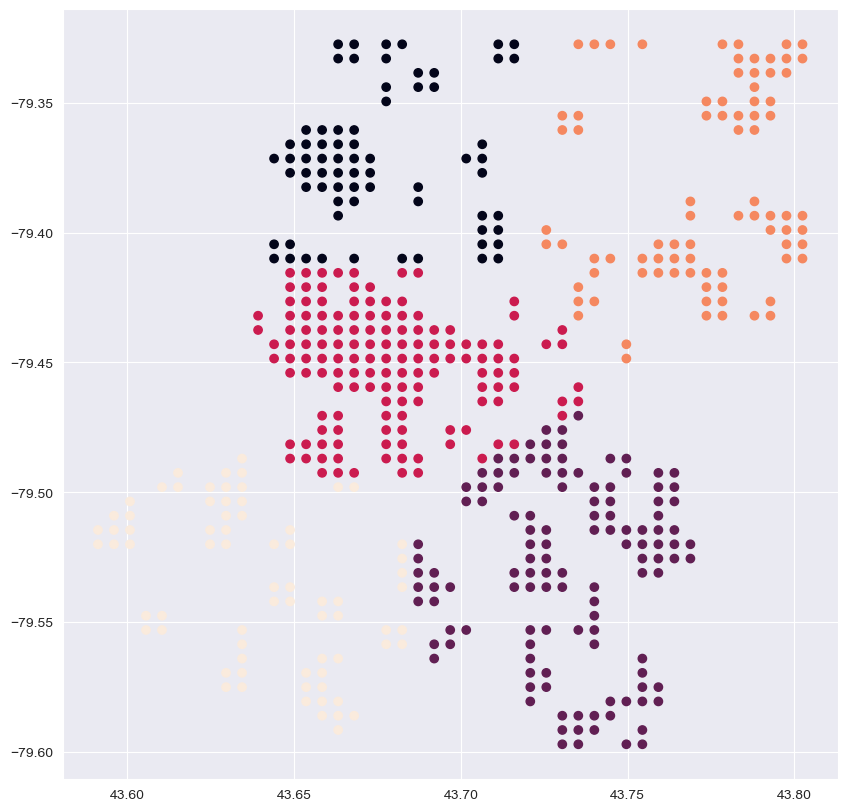

In [78]:
fig = plt.figure()
ax = fig.add_subplot()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.scatter(YYZ_C_Scores["lat"], YYZ_C_Scores["long"], c=kmeans.labels_.astype(float))

In [79]:
YYZ_C_Scores['cluster'] = kmeans.labels_.tolist()

In [80]:
def getLine(scores, upper, bottom, left, right):
    [*line, line_intercept, line_coefficients] = polynomialRegression(scores, 5, upper, bottom)
    line = trimOutOfBounds(line, upper, bottom, left, right)
    line = snapLongToGrid(line, left, right)
    return (line, line_intercept, line_coefficients)

In [81]:
YYZ_Cx_Scores = []
for i in range(NUM_CLUSTERS):
    YYZ_Cx_Scores.append(YYZ_C_Scores.loc[YYZ_C_Scores['cluster'] == i])

In [82]:
YYZ_Cx_Line = []
for i in range(NUM_CLUSTERS):
    [line, _, _] = getLine(YYZ_Cx_Scores[i], YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)
    YYZ_Cx_Line.append(line)

<AxesSubplot:xlabel='lat', ylabel='long'>

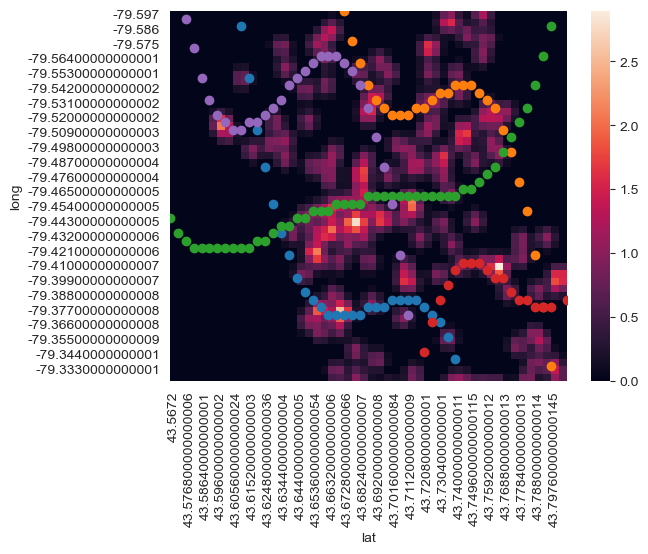

In [83]:
plotHeatmapPolynomial(YYZ_Scores, YYZ_Cx_Line)

In [70]:
YYZ_Cx_Line

[(array([43.6008, 43.6056, 43.6104, 43.6152, 43.62  , 43.6248, 43.6296,
         43.6344, 43.6392, 43.644 , 43.6488, 43.6536, 43.6584, 43.6632,
         43.668 , 43.6728, 43.6776, 43.6824, 43.6872, 43.692 , 43.6968,
         43.7016, 43.7064, 43.7112, 43.716 , 43.7208, 43.7256, 43.7304,
         43.7352, 43.74  , 43.7448, 43.7496, 43.7544, 43.7592, 43.764 ]),
  array([-79.597 , -79.564 , -79.531 , -79.5035, -79.476 , -79.454 ,
         -79.4375, -79.421 , -79.4045, -79.399 , -79.388 , -79.3825,
         -79.377 , -79.3715, -79.3715, -79.3715, -79.3715, -79.377 ,
         -79.377 , -79.377 , -79.3825, -79.3825, -79.388 , -79.388 ,
         -79.3935, -79.3935, -79.3935, -79.388 , -79.388 , -79.3825,
         -79.377 , -79.366 , -79.355 , -79.344 , -79.3275])),
 (array([43.668 , 43.6728, 43.6776, 43.6824, 43.6872, 43.692 , 43.6968,
         43.7016, 43.7064, 43.7112, 43.716 , 43.7208, 43.7256, 43.7304,
         43.7352, 43.74  , 43.7448, 43.7496, 43.7544, 43.7592, 43.764 ,
         43.768

### Toronto Test (Preliminary Work for Interchanges)

In [39]:
YYZ_T_Scores = YYZ_C_Scores.copy()

In [40]:
lineDf = pd.DataFrame({'lat': YYZ_Line_1[0], 'long': YYZ_Line_1[1]})
lineScores = np.empty(1)
for index, row in lineDf.iterrows():
    ptScore = YYZ_T_Scores.loc[(abs(YYZ_T_Scores['lat'] - row['lat']) <= 0.00001) & (abs(YYZ_T_Scores['long'] - row['long']) <= 0.00001), 'score']
    lineScores = np.append(lineScores, ptScore.values, axis = 0)
station_threshold = np.percentile(lineScores, 50)
for index, row in lineDf.iterrows():
    #YYZ_T_Scores.score[(abs(YYZ_T_Scores['lat'] - row['lat']) <= 0.00001) & (abs(YYZ_T_Scores['long'] - row['long']) <= 0.00001) & (YYZ_T_Scores['score'] >= 0)] *= 10
    for i, r in YYZ_T_Scores.iterrows():
        flippedLong = YYZ_RightLongBound - (row["long"] - YYZ_LeftLongBound)
        nodeScore = 2*score(row["lat"], row["long"], r["lat"].reshape(1, -1), r["long"].reshape(1, -1), 0.9)
        YYZ_T_Scores.at[i, 'score'] = YYZ_T_Scores.at[i, 'score'] + nodeScore

<Axes3DSubplot:>

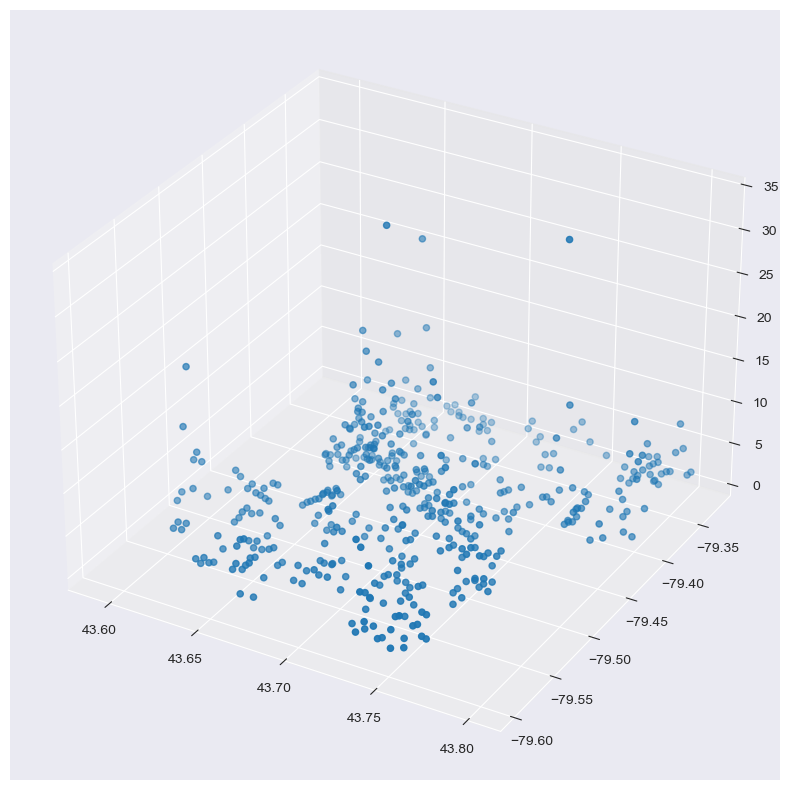

In [41]:
plotScores(YYZ_T_Scores)

In [42]:
[*YYZ_Line_2, YYZ_Line_2_intercept, YYZ_Line_2_coefficients] = polynomialRegression(YYZ_T_Scores, 11, YYZ_UpperLatBound, YYZ_BottomLatBound)
YYZ_Line_2 = trimOutOfBounds(YYZ_Line_2, YYZ_UpperLatBound, YYZ_BottomLatBound, YYZ_LeftLongBound, YYZ_RightLongBound)
YYZ_Line_2 = snapLongToGrid(YYZ_Line_2, YYZ_LeftLongBound, YYZ_RightLongBound)

In [43]:
plotHeatmapPolynomial(YYZ_C_Scores, [YYZ_Line_C, YYZ_Line_2])

NameError: name 'YYZ_Line_C' is not defined

In [ ]:
YYZ_Line_1_intercept, YYZ_Line_1_coefficients